In [91]:
import random
import numpy as np
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Simple coupling of randomly moving dots

- 2d grid based environment with 1d "moving" dots
- array of possible moves (things don't teleport, in the 2d grid there are 0 basic moves + no move)
- how to identify objects in the grid? how to track them in time? identity identified by position at t0 and trajectory of position changes -> what happens with coupling?
- coupling through adjacency

#### SETUP

In [94]:
M_DIM = 100 # space
m = np.zeros(shape=(M_DIM, M_DIM))
frames = 200 # time
N = 50 # dots

# mves
moves = [(-1, 0), (1, 0), (0, -1), (0, 1),
         (-1, -1), (-1, 1), (1, -1), (1, 1), (0,0)]

# init positions
init_pos = [[random.randint(0,M_DIM-1), random.randint(0,M_DIM-1)] for _ in range(N)]
positions = [[pos.copy() for pos in init_pos]]

#### HELPERS

In [95]:
# Track adjacency counters for each pair
adjacency_counter = {}
for i, j in combinations(range(N), 2):
    adjacency_counter[(i, j)] = 0

# Track groups: each dot starts in its own group
groups = [{i} for i in range(N)]

def are_adjacent(pos1, pos2):
    return max(abs(pos1[0] - pos2[0]), abs(pos1[1] - pos2[1])) == 1

def find_group(groups, idx):
    for g in groups:
        if idx in g:
            return g
    return None

#### SIM

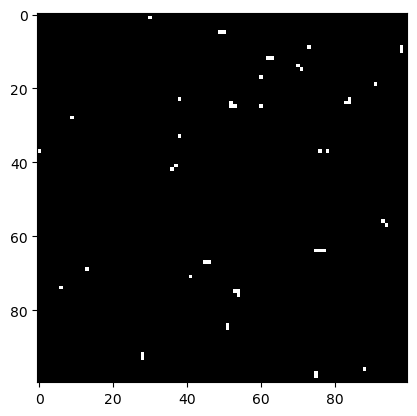

In [96]:
for frame in range(frames - 1):
    prev = [pos.copy() for pos in positions[-1]]

    # Update adjacency counters
    for (i, j) in adjacency_counter:
        if are_adjacent(prev[i], prev[j]):
            adjacency_counter[(i, j)] += 1
        else:
            adjacency_counter[(i, j)] = 0

    # Merge groups if any pair has been adjacent for 2 consecutive frames
    merged = True
    while merged:
        merged = False
        for (i, j), count in adjacency_counter.items():
            if count >= 2:
                gi = find_group(groups, i)
                gj = find_group(groups, j)
                if gi is not gj:
                    gi.update(gj)
                    groups.remove(gj)
                    merged = True
                    break

    # Move each group together
    new_frame = prev.copy()
    for group in groups:
        move = moves[random.randint(0, len(moves)-1)]
        # Compute new positions for the group
        group_new_positions = []
        for idx in group:
            pos = prev[idx]
            new_pos = [pos[0] + move[0], pos[1] + move[1]]
            new_pos[0] = np.clip(new_pos[0], 0, M_DIM-1)
            new_pos[1] = np.clip(new_pos[1], 0, M_DIM-1)
            group_new_positions.append(new_pos)
        # Update all positions in the group
        for idx, new_pos in zip(group, group_new_positions):
            new_frame[idx] = new_pos

    positions.append(new_frame)

fig, ax = plt.subplots()
im = ax.imshow(m, cmap='gray', vmin=0, vmax=1, animated=True)

def update(frame):
    m[:] = 0
    for pos in positions[frame]:
        m[pos[0], pos[1]] = 1
    im.set_array(m)
    return [im]

ani = FuncAnimation(fig, update, frames=frames, blit=True, interval=50)
HTML(ani.to_jshtml())

<iframe width="500" height="500" src="animation.mp4"></iframe>

{{< video animation.mp4 >}}

----

## MARKOV BLANKET

- If a dot becomes surrounded by others, its moves are fully determined by them and changes state (1->0.5)